<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


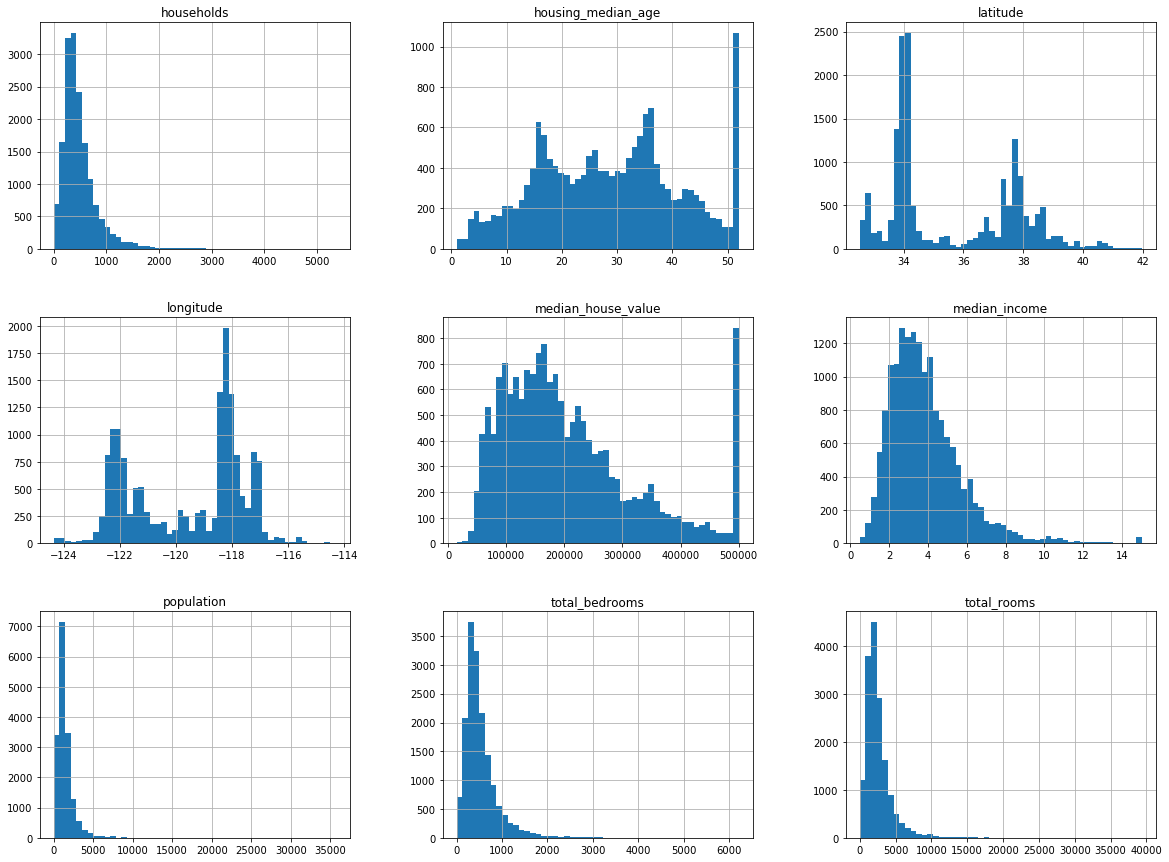

Predictions:	 [ 210528.01750105  317824.00920324  210815.82440675   59307.5245779
  189946.78983305]
LABELS:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]
68635.5935252
0.0
Scores: [ 70046.87206606  64910.65859557  74464.33621012  70556.43800074
  70022.5928811   73642.06202393  71369.46954122  71463.04074844
  71468.48273552  67654.20784255]
Mean: 70559.8160645
Standard deviation: 2606.71857662
Scores: [ 66780.80311827  66939.08505782  70380.83790115  74469.61166289
  68042.55318962  71196.31002382  64973.23018016  68285.42317144
  70978.93569734  67670.63282586]
Mean: 68971.7422828
Standard deviation: 2629.39092157


c:\users\xusy\anaconda3\envs\har\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores: [ 49957.8420036   49482.5508385   52887.40958371  53658.66955481
  52509.00168602  55541.04356086  50955.13363169  54704.62549972
  54454.53009171  52504.09867166]
Mean: 52665.4905122
Standard deviation: 1926.17533691


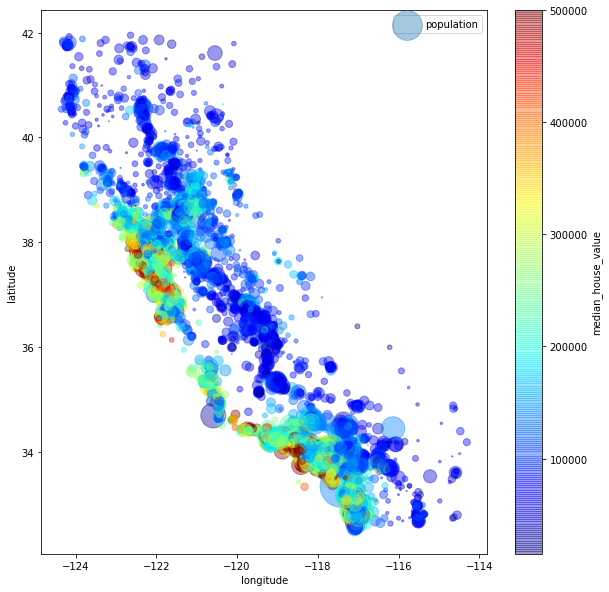

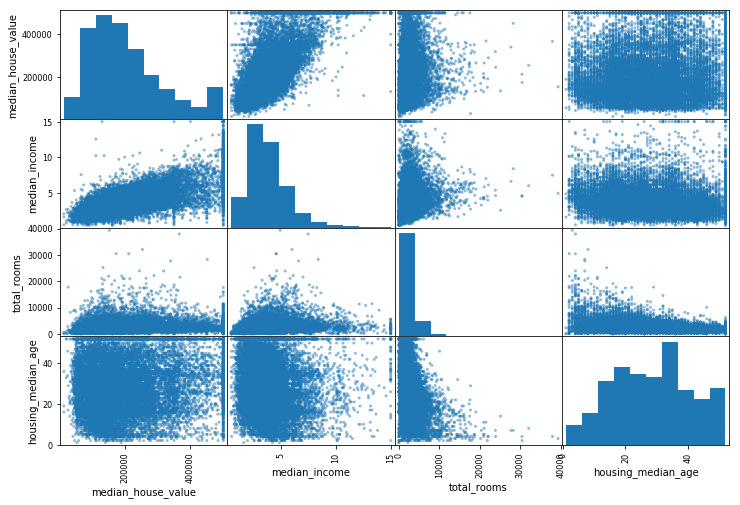

In [4]:
# 1. 数据载入
'''
# 数据下载部分
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = housing_path + "/housing.tgz"
    # print(tgz_path)
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()
'''
import os
import numpy as np
import pandas as pd

HOUSING_PATH = "datasets/housing"
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

# 2. 数据集的划分，划分为训练集和测试集
'''
# 2.1 随机采样
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
'''
# 2.2 分层采样
from sklearn.model_selection import StratifiedShuffleSplit

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)
    
housing = strat_train_set.copy()

# 3. 数据探索
housing.head()
housing.info()
housing.describe()
# 3.1 绘图plotting
%matplotlib inline
import matplotlib.pyplot as plt
# 3.2 直方图
housing.hist(bins=50,figsize=(20,15))
plt.show()
# 3.3 根据经纬度画图， label的scaler按照人口缩放 色彩图按照中值价格划分
housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.4,
            s = housing["population"]/20, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar = True,figsize=(10,10))
plt.legend()
# 3.4 属性的相关矩阵，衡量“线性”相关性。
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
# 3.5 相关矩阵画图
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))
# 3.6 探索复合属性
'''
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_househlod"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending =False)
'''
# 4. 数据准备

# 将训练集的训练属性与标签分离开
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
# 4.1 缺失值处理
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
# 获取数值类属性
housing_num = housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X,columns=housing_num.columns)

# 4.2 非数值编码转化OneHot或直接二进制化
'''
# 非数值编码
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)

# 编码OneHot化
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1)) #-1是不给第一维度大小
housing_cat_1hot.toarray()

'''
# 二进制化
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat = housing["ocean_proximity"]
housing_cat_1hot = encoder.fit_transform(housing_cat)

# 4.3 创建自己所需的属性列的transformer
# 增加复合属性的transformer
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix,population_ix, household_ix =3, 4 ,5 ,6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:,rooms_ix] / X[:,household_ix]
        population_per_household =X[:,population_ix] / X[:,population_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/ X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
# 4.4 数据规范化，包括正则化和标准化
# 正则化采用 minmax的transformer
# 标准化采用 standardscaler的transformer

# 4.5 采用管道化来完成顺序操作
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

# 4.6 总体数据处理管道操作以及不同类别属性的联合
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
from sklearn.base import TransformerMixin

class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attribs)),
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attribs)),
    ("label_binarizer", MyLabelBinarizer()),
])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline),
    ("cat_pipeline",cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)

# 5. 模型训练与验证
# 5.1 线性回归
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("LABELS:\t\t", list(some_labels))

# 5.2 均方根误差估计
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

# 5.3 决策树回归
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

# 5.4 k折交叉验证
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
from sklearn.model_selection import cross_val_score
# 决策树10折
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

display_scores(tree_rmse_scores)
# 线性回归10折
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

# 随机森林10折
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

# 5.5 模型保存与载入
from sklearn.externals import joblib

joblib.dump(forest_reg,"my_forest_reg.pkl")
my_model_loaded = joblib.load("my_forest_reg.pkl")

In [5]:
# 6. 模型调优
# 6.1 网格搜索
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(np.sqrt(-grid_search.best_score_))

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [12]:
# 6.2 随机搜索和集成方法
# 6.3 分析最佳模型和其误差
feature_importances = grid_search.best_estimator_.feature_importances_
# print(feature_importances)
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38610749304496744, 'median_income'),
 (0.15053544715570144, 'INLAND'),
 (0.096625080529498447, 'longitude'),
 (0.0883919413634984, 'latitude'),
 (0.077829921407424979, 'bedrooms_per_room'),
 (0.046503195597511822, 'housing_median_age'),
 (0.040387523741718154, 'rooms_per_hhold'),
 (0.030124408927853102, 'population'),
 (0.022823524806210305, 'total_rooms'),
 (0.022221807718089889, 'total_bedrooms'),
 (0.020873998383270705, 'households'),
 (0.0082601446888006559, '<1H OCEAN'),
 (0.006467688935314503, 'NEAR OCEAN'),
 (0.0028152151809095549, 'NEAR BAY'),
 (3.2608519230533661e-05, 'ISLAND'),
 (0.0, 'pop_per_hhold')]

In [15]:
# 7. 在测试集上测试
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 48,209.6
print(final_rmse)

48206.1981371


In [4]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = housing_path + "/housing.tgz"
    # print(tgz_path)
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

In [15]:
fetch_housing_data()

datasets/housing/housing.tgz


In [7]:
housing = load_housing_data()

housing.head()

housing.info()

In [19]:
housing["ocean_proximity"].value_counts()

housing["total_rooms"].value_counts()

housing.describe()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

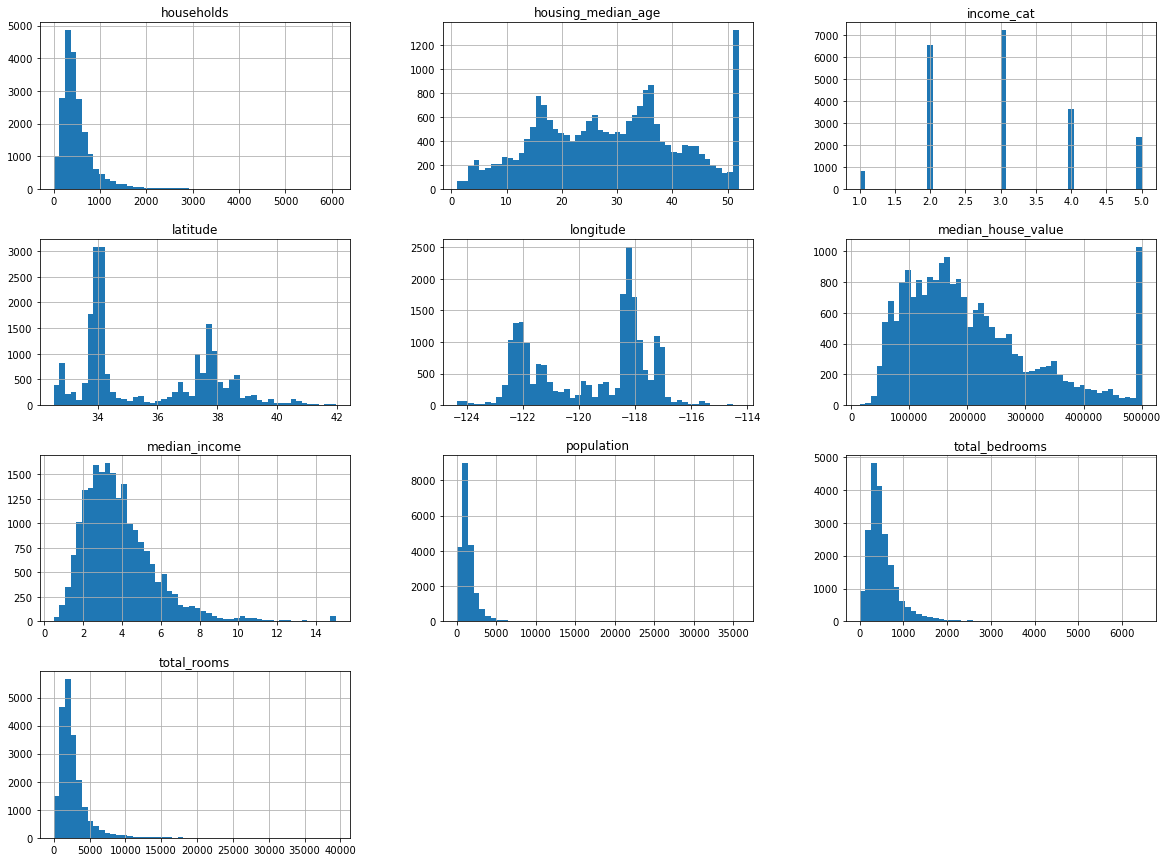

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.show()

In [24]:
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices =np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [27]:
train_set, test_set = split_train_test(housing, 0.2)

In [28]:
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [10]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash = hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index() # 用行号做id

In [18]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [19]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [21]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [22]:
train_set

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14196    -117.03     32.71                33.0       3126.0           627.0   
8267     -118.16     33.77                49.0       3382.0           787.0   
17445    -120.48     34.66                 4.0       1897.0           331.0   
14265    -117.11     32.69                36.0       1421.0           367.0   
2271     -119.80     36.78                43.0       2382.0           431.0   
17848    -121.86     37.42                20.0       5032.0           808.0   
6252     -117.97     34.04                28.0       1686.0           417.0   
9389     -122.53     37.91                37.0       2524.0           398.0   
6113     -117.90     34.13                 5.0       1126.0           316.0   
6061     -117.79     34.02                 5.0      18690.0          2862.0   
16030    -122.45     37.72                52.0        982.0           197.0   
8364     -118.35     33.97                25.0       1864.0           616.0   
9448     -119.72     37.46                13.0       1999.0           375.0   
17529    -121.88     37.33                36.0       1904.0           689.0   
5865     -118.34     34.18                46.0       1393.0           301.0   
7615     -118.23     33.89                36.0       2598.0           514.0   
9707     -121.65     36.67                52.0       2351.0           459.0   
16332    -121.34     38.03                20.0       4213.0           751.0   
3449     -118.43     34.32                34.0       2657.0           515.0   
5199     -118.28     33.93                21.0        847.0           278.0   
13496    -117.34     34.16                31.0       1606.0           354.0   
18056    -121.98     37.24                35.0       3574.0           485.0   
9529     -123.15     38.94                22.0       2163.0           436.0   
5128     -118.28     33.98                43.0       1240.0           312.0   
18796    -122.31     40.89                18.0        754.0           161.0   
413      -122.28     37.89                52.0       2070.0           329.0   
1175     -121.57     39.48                15.0        202.0            54.0   
4387     -118.26     34.08                46.0        945.0           250.0   
11628    -118.07     33.80                22.0       1391.0           338.0   
9787     -120.79     36.06                29.0       1916.0           386.0   
...          ...       ...                 ...          ...             ...   
1267     -121.68     37.93                44.0       1014.0           225.0   
1899     -120.01     38.89                24.0       1669.0           422.0   
3005     -119.07     35.27                25.0       3081.0           635.0   
19118    -122.65     38.23                52.0       1923.0           393.0   
189      -122.24     37.79                47.0       1372.0           395.0   
2747     -115.57     32.78                20.0       1534.0           235.0   
18431    -121.85     37.26                16.0       1982.0           280.0   
18942    -122.08     38.30                 2.0       6718.0           858.0   
8666     -118.43     33.83                19.0       6206.0          1611.0   
6396     -118.03     34.14                44.0       1446.0           250.0   
19769    -122.11     39.82                27.0       1065.0           214.0   
17568    -121.93     37.32                52.0       1460.0           492.0   
6420     -117.98     34.14                27.0       6341.0          1289.0   
5051     -118.34     34.01                35.0       1359.0           359.0   
5311     -118.43     34.06                41.0       1463.0           267.0   
2433     -119.63     36.60                33.0       1589.0           294.0   
769      -122.09     37.65                35.0       1184.0           200.0   
1685     -122.28     37.99                28.0       3801.0           622.0   
8322     -118.30     33.95                41.0       2057

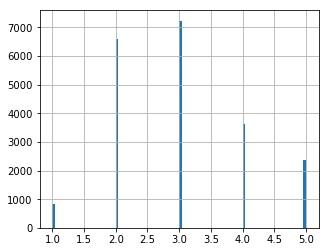

In [21]:
housing["income_cat"].hist(bins=100,figsize=(5,4))
plt.show()

In [26]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [28]:
housing["income_cat"].value_counts()/ len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [29]:
strat_test_set["income_cat"].value_counts()/ len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [30]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

In [31]:
housing = strat_train_set.copy()

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.01)
#alpha 透明度淡化了使得同一点多的地方显得明显

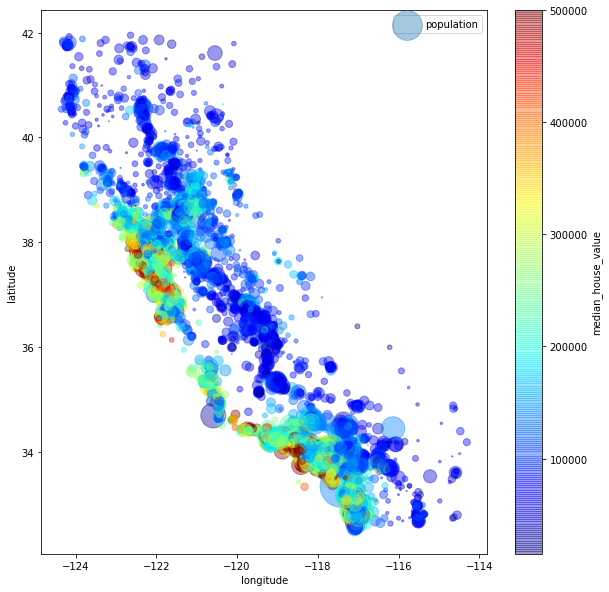

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.4,
            s = housing["population"]/20, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar = True,figsize=(10,10))
plt.legend()

In [33]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

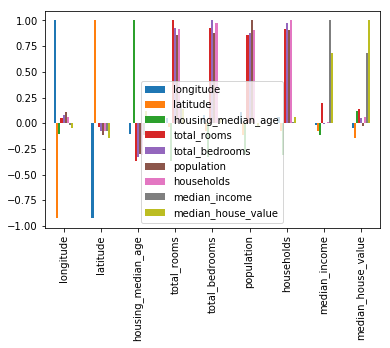

In [38]:
corr_matrix.plot.bar()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249CB006320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000249CB60F550>]], dtype=object)

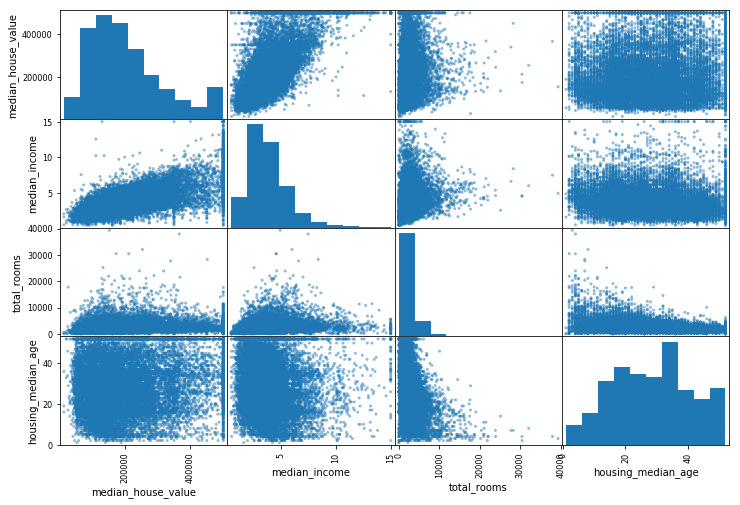

In [46]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

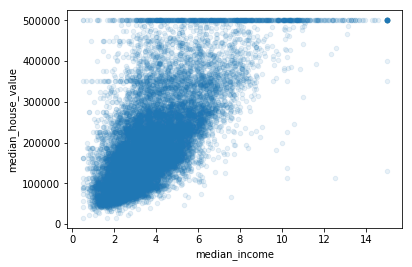

In [48]:
housing.plot(kind="scatter",x="median_income", y="median_house_value",alpha=0.1)

In [49]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_househlod"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending =False)

In [33]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [52]:
'''
# option1 消灭缺失值的样本
housing.dropna(subset=["total_bedroom"])
# option2 消除有缺失的属性
housing.drop("total_bedroom",axis=1)
# option3 填充缺失值（用0，均值，中值等）
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

'''

'\n# option1 消灭缺失值的样本\nhousing.dropna(subset=["total_bedroom"])\n# option2 消除有缺失的属性\nhousing.drop("total_bedroom",axis=1)\n# option3 填充缺失值（用0，均值，中值等）\nmedian = housing["total_bedrooms"].median()\nhousing["total_bedrooms"].fillna(median)\n\n'

In [34]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

c:\users\xusy\anaconda3\envs\har\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [35]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity",axis=1)

imputer.fit(housing_num)

imputer.statistics_

housing_num.median().values

X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X,columns=housing_num.columns)

In [43]:
housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [44]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [45]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [46]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

c:\users\xusy\anaconda3\envs\har\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [60]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix,population_ix, household_ix =3, 4 ,5 ,6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:,rooms_ix] / X[:,household_ix]
        population_per_household =X[:,population_ix] / X[:,population_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/ X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [50]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422, 1.0],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124, 1.0],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225, 1.0],
       ..., 
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817, 1.0],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809, 1.0],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295, 1.0]], dtype=object)

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',Imputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

c:\users\xusy\anaconda3\envs\har\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [52]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
         0.        ,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
         0.        , -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
         0.        ,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
         0.        , -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.        , -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
         0.        ,  0.10180567]])

In [76]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [79]:
from sklearn.base import TransformerMixin

class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)


In [82]:
from sklearn.pipeline import FeatureUnion
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attribs)),
    ('imputer',Imputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attribs)),
    ("label_binarizer", MyLabelBinarizer()),
])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline),
    ("cat_pipeline",cat_pipeline),
])

c:\users\xusy\anaconda3\envs\har\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [83]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [64]:
housing_num

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   
19480    -120.97     37.66                24.0       2930.0           588.0   
8879     -118.50     34.04                52.0       2233.0           317.0   
13685    -117.24     34.15                26.0       2041.0           293.0   
4937     -118.26     33.99                47.0       1865.0           465.0   
4861     -118.28     34.02                29.0        515.0           229.0   
16365    -121.31     38.02                24.0       4157.0           951.0   
19684    -121.62     39.14                41.0       2183.0           559.0   
19234    -122.69     38.51                18.0       3364.0           501.0   
13956    -117.06     34.17                21.0       2520.0           582.0   
2390     -119.46     36.91                12.0       2980.0           495.0   
11176    -117.96     33.83                30.0       2838.0           649.0   
15614    -122.41     37.81                25.0       1178.0           545.0   
2953     -119.02     35.35                42.0       1239.0           251.0   
13209    -117.72     34.05                 8.0       1841.0           409.0   
6569     -118.15     34.20                46.0       1505.0           261.0   
5825     -118.30     34.19                14.0       3615.0           913.0   
18086    -122.05     37.31                25.0       4111.0           538.0   
16718    -120.66     35.49                17.0       4422.0           945.0   
13600    -117.25     34.16                37.0       1709.0           278.0   
13989    -117.19     34.94                31.0       2034.0           444.0   
15168    -117.06     33.02                24.0        830.0           190.0   
6747     -118.07     34.11                41.0       2869.0           563.0   
7398     -118.24     33.96                44.0       1338.0           366.0   
5562     -118.28     33.91                41.0        620.0           133.0   
16121    -122.46     37.79                52.0       2059.0           416.0   
...          ...       ...                 ...          ...             ...   
12380    -116.47     33.77                26.0       4300.0           767.0   
5618     -118.23     33.78                20.0         59.0            24.0   
10060    -121.06     39.25                17.0       3127.0           539.0   
18067    -122.03     37.29                22.0       3118.0           438.0   
4471     -118.17     34.09                33.0       2907.0           797.0   
19786    -122.86     40.56                12.0       1350.0           300.0   
9969     -122.48     38.51                49.0       1977.0           393.0   
14621    -117.17     32.78                17.0       3845.0          1051.0   
579      -122.07     37.71                40.0       1808.0           302.0   
11682    -118.01     33.87                25.0       6348.0          1615.0   
245      -122.21     37.78                43.0       1702.0           460.0   
12130    -117.23     33.94                 8.0       2405.0           537.0   
16441    -121.29     38.14                34.0       2770.0           544.0   
11016    -117.82     33.76                33.0       2774.0           428.0   
19934    -119.34     36.31                14.0       1635.0           422.0   
1364     -122.14     38.03                42.0        118.0            34.0   
1236     -120.37     38.23                13.0       4401.0           829.0   
5364     -118.42     34.04                52.0       1358.0           272.0   
11703    -117.97     33.88                16.0       2003

In [84]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [85]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("LABELS:\t\t", list(some_labels))

Predictions:	 [ 210528.01750105  317824.00920324  210815.82440675   59307.5245779
  189946.78983305]
LABELS:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [87]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68635.593525169825

In [88]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0

In [90]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [ 70398.41961164  66122.90849808  73371.68594907  69832.20625422
  71122.51677162  75755.11521084  69110.38625876  70066.92373447
  69697.8440743   69204.66177088]
Mean: 70468.2668134
Standard deviation: 2455.51230878


In [91]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [ 70398.41961164  66122.90849808  73371.68594907  69832.20625422
  71122.51677162  75755.11521084  69110.38625876  70066.92373447
  69697.8440743   69204.66177088]
Mean: 70468.2668134
Standard deviation: 2455.51230878


In [92]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

c:\users\xusy\anaconda3\envs\har\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [94]:
from sklearn.externals import joblib

joblib.dump(forest_reg,"my_forest_reg.pkl")

my_model_loaded = joblib.load("my_forest_reg.pkl")

['my_forest_reg.pkl']

In [96]:
my_model_loaded

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)